<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea6_c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator
import matplotlib
import statsmodels.tools.eval_measures as bias
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
from mpl_toolkits.mplot3d import Axes3D # Axes3D import has side effects, it enables using projection='3d' in add_subplot
from math import ceil
from scipy import linalg
from os import listdir
from numpy.random import uniform, normal
from numpy.linalg import *
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.neighbors import KernelDensity
from statsmodels.nonparametric.kernel_regression import KernelReg
import time
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Regresión local en $\mathcal{Rp}$

Se implementa el método de regresión (lineal) local con suavización con kernel en multiples dimensiones $p$ en cada punto de una variable dependiente.

La implementación fue realizada basada en las consideraciones del libro [The Elements of Statistical Learning](https://link.springer.com/book/10.1007/978-0-387-84858-7) secciones; 6.1 One-Dimensional Kernel Smoothers; 6.1.1 Local Linear Regression; y 6.3 Local Regression in IRp.

## Un ejemplo sencillo de regresión local en $\mathcal{Rp}$  con pocos datos
Los datos usados en esta sección están disponibles en [minitest.csv](https://drive.google.com/file/d/10Shxgajmm_loJf_3PrD6rQBF6-UqEOH3/view?usp=sharing)

In [2]:
df  = pd.read_csv('minitest.csv')
X   = pd.DataFrame(df[['X1','X2','X3','X4']]).to_numpy()
Y   = pd.DataFrame(df[['Y']]).to_numpy()

Iniciamos calcuando los pesos de los puntos $x_i\in\mathcal{Rp}$ del vecindario alrededor del punto $x_o\in\mathcal{Rp}$.

Damos mayor peso a las puntos $x_i$ mas cercanos al punto $x_o$ y menos peso a las observaciones más lejanas. 
Calcularemos los pesos de los puntos utilizando un kernel que asigna importancia a cada uno de los k vecinos de $x_i$ según su distancia a $x_o$.

In [3]:
# Calcula los pesos y regresa una matriz diagonal con los pesos
def get_weight_exp(xo, X, k): 
## k    : tamanio del vecindario (bandwidth)
## X    : Regresores
## xo   : punto donde se desea hacer la predicción.

    n = X.shape[0]             ## numero de datos
    weight = np.mat(np.eye(n)) ## Matriz de pesos identidad W.
    
  # Cálculo de pesos para todos los datos de entrenamiento xi.
    for i in range(n): 
        xi = X[i] 
        d = (-2 * k * k) 
        weight[i, i] = np.exp(np.dot((xi-xo), (xi-xo).T)/d)        
    return weight

A continuación estimamos los coeficientes de regresión `β = (Xt W(xo) X)^{-1}) (Xt W Y)` con la matrix de pesos `W`.

In [4]:
from pandas.core.indexing import IndexSlice
def local_regression(XX,xxo,k):
    ## X    : Regresores.
    ## xo   : punto donde se desea hacer la predicción.
    ## k    : tamanio del vecindario (bandwidth).

    X  = np.copy(XX)
    xo = np.copy(xxo)
    Flag = True
    while(Flag == True):
        try:
            n = X.shape[0]             ## numero de datos
            weight = np.mat(np.eye(n)) ## Matriz de pesos identidad W.
                
            # Cálculo de pesos para todos los datos de entrenamiento xi.
            for i in range(n): 
                xi = X[i] 
                d = (-2 * k * k)
                weight[i, i] = np.exp(np.dot((xi-xo), (xi-xo).T)/d)  #Matriz diagonal de pesos

            Xt = X.T  # Calcula transpuesta de X
            A = np.matmul(Xt, np.matmul(weight,X)) 
            A = np.linalg.inv(A)   # Calcula inversa de A
            B = np.matmul(Xt, np.matmul(weight,Y)) 
            beta = np.matmul(A,B)
            prediccion = np.matmul(xo,beta)

        except Exception as e:
            print(e,str(len(X[0])))
            dfX = pd.DataFrame(X)
            vif = pd.DataFrame()
            vif["VIF Factor"] = [variance_inflation_factor(dfX.values, i) for i in range(dfX.values.shape[1])]
            vif["features"] = dfX.columns
            pd.set_option('display.max_rows', 300)
            #print(vif.round(2))
            column = vif["VIF Factor"]
            max_value = column.max()
            ind = vif[vif['VIF Factor']==max_value].index
            X = np.delete(X, ind, 1)  # delete ind column of C
            xo = np.delete(xo, ind, 1)  # delete ind column of C
            X = X + uniform()

        else:
          Flag = False

    return prediccion

En esta función se recorre uno a uno los puntos de la función de `X_test` para calcular la predicción. Es decir, para cada uno de los datos, seleccionaremos una vecindad de k puntos muestreados y los usaremos como conjunto de entrenamiento para un problema de regresión lineal con pesos. Aunque ajustamos un modelo lineal completo a los datos de la vecindad, solamente lo usamos para evaluar el ajuste en el único punto `xo`.

In [5]:
k = 5 # Tamanio del vecindario 
Y_local = []
for i in range(X.shape[0]):
    xo = X[[i]]
    Ygorro = local_regression(X, xo, k)
    Y_local.append(Ygorro.item(0))

Singular matrix 4
Singular matrix 4
Singular matrix 4


En esta sección calculamos la predicción usando unicamente la regresión lineal múltiple. Como se observa los pesos `W` son la matriz identidad.

In [6]:
Y_pred = []
olsmod = sm.OLS(Y, X)
olsres = olsmod.fit()
Y_pred = olsres.predict(X)

No handles with labels found to put in legend.


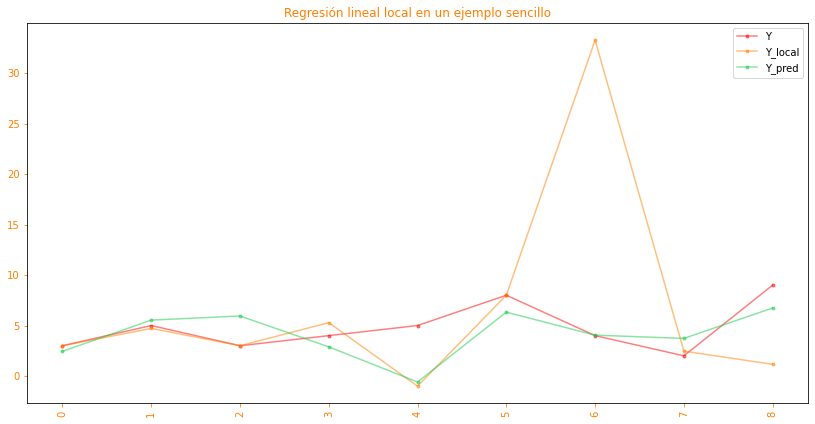

In [7]:
fig  = plt.figure(figsize=(14,7))
axes = fig.add_subplot(1, 1, 1)
#plt.style.use("seaborn-poster")
axes.legend()
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff';
mytitle = plt.title('Regresión lineal local en un ejemplo sencillo') # get the title property handler #plt.getp(title_obj)
plt.setp(mytitle,    color=LETRASNARA)                                        #set the color of title to red
axes.xaxis.label.set_color(LETRASNARA)
axes.yaxis.label.set_color(LETRASNARA)
axes.tick_params(   colors=LETRASNARA, which='both')

axes.plot  ( Y      , '.-'  , color = 'red'        , label = 'Y'        ,alpha=1/2)
axes.plot  ( Y_local, '.-'  , color = LETRASNARA   , label = 'Y_local'  ,alpha=1/2)
axes.plot  ( Y_pred , '.-'  , color = VERDE        , label = 'Y_pred'   ,alpha=1/2)
#axes.plot ( xspline[3], yspline[3] , '.-'  , color = VEDE   , label = 'orden=4'  ,alpha=1/2)
#axes.plot ( xspline[4], yspline[4] , '.-'  , color = AZUL   , label = 'orden=5'  ,alpha=1/12)
#AUX = np.arange( len(Y) )
#plt.scatter( AUX,    Y,     s=25 ,  marker='o' , color = 'red'   , label = 'X'        ,alpha=1)
#plt.scatter( dfx_miss, dfy_miss, marker='x',  s=170 ,  color = 'red' , label = 'perdidos' ,alpha=1)

#plt.axis([0,  600, 7400, 9800])
#plt.axis([150, 300, 7400, 9800])
plt.legend()  
plt.xticks(rotation=90)
plt.savefig('pronodemanda_t6_x.png', transparent=True)
plt.show()

## Regresión local en $\mathcal{Rp}$ en predicción de demanda eléctrica

A continuación haremos la comparación de resultados de regresión para datos de demanda eléctrica. La variable independiente $X$ serán los datos de demanda del día anterior, y los datos independiente $Y$ serán los datos de días con una mayor correlación con $X$. En esta sección, aplicaremos técnicas de regresión local con multiples regresores $X$.

Los datos usados en esta sección están disponibles en [demanda.csv](https://drive.google.com/file/d/1KpY2p4bfVEwGRh5tJjMx9QpH6SEwrUwH/view?usp=sharing)

In [8]:
from sklearn import preprocessing
from numpy import asarray
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('demanda.csv')

## Estandarizamos 
#df = df - df.mean(numeric_only = True)
#df = df / df.std(numeric_only = True)

X = pd.DataFrame(df[['X1','X2','X3','X4','X5','X6','X7','X8','X9']]).to_numpy()
X = pd.DataFrame(df[['X1','X2','X3','X4','X5','X6']]).to_numpy()
X = pd.DataFrame(df[['X1']]).to_numpy()
X = pd.DataFrame(df[['X1','X2']]).to_numpy()

Y = pd.DataFrame(df[['Y']]).to_numpy()

## Otra manera de estandarizar
#scaler = StandardScaler()
#X = scaler.fit_transform(X)
#Y = scaler.fit_transform(Y)

#X = X + uniform()

En esta función se recorre uno a uno los puntos de la función de `X_test` para calcular la predicción. Es decir, para cada uno de los datos, seleccionaremos una vecindad de k puntos muestreados y los usaremos como conjunto de entrenamiento para un problema de regresión lineal con pesos. Aunque ajustamos un modelo lineal completo a los datos de la vecindad, solamente lo usamos para evaluar el ajuste en el único punto `xo`. 

In [9]:
k = 0 # Tamanio del vecindario
klist = [10,15,25,35,50,100,150]
#klist  = [80,100,150,200,250]
Y_local_list = []
aux=0
for item in klist:
    k = item
    Y_local = []
    for i in range(X.shape[0]):
        xo = X[[i]]
        Ygorro = local_regression(X, xo, k)
        Y_local.append(Ygorro.item(0))
        aux = Ygorro.item(0)
        
    Y_local_list.append(Y_local)

Singular matrix 2
Singular matrix 2
Singular matrix 2
Singular matrix 2
Singular matrix 2


En esta sección calculamos la predicción usando unicamente la regresión lineal múltiple. Como se observa en este caso los pesos `W` son la matriz identidad.

In [10]:
Y_pred = []
olsmod = sm.OLS(Y, X)
olsres = olsmod.fit()
Y_pred = olsres.predict(X)

Calculamos los errores de los métodos de regresión comparados, variando además los tamaños de las vecindades `k`.

In [11]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

In [12]:
mae_pred  = trunc(mean_absolute_error(Y,Y_pred),4)
mae_local_k0 = trunc(mean_absolute_error(Y,Y_local_list[0]),4)
mae_local_k1 = trunc(mean_absolute_error(Y,Y_local_list[1]),4)
mae_local_k2 = trunc(mean_absolute_error(Y,Y_local_list[2]),4)
mae_local_k3 = trunc(mean_absolute_error(Y,Y_local_list[3]),4)
mae_local_k4 = trunc(mean_absolute_error(Y,Y_local_list[4]),4)
mae_local_k5 = trunc(mean_absolute_error(Y,Y_local_list[5]),4)
mae_local_k6 = trunc(mean_absolute_error(Y,Y_local_list[6]),4)

In [13]:
mse_pred  = trunc(mean_squared_error(Y,Y_pred),4)
mse_local_k0 = trunc(mean_squared_error(Y,Y_local_list[0]),4)
mse_local_k1 = trunc(mean_squared_error(Y,Y_local_list[1]),4)
mse_local_k2 = trunc(mean_squared_error(Y,Y_local_list[2]),4)
mse_local_k3 = trunc(mean_squared_error(Y,Y_local_list[3]),4)
mse_local_k4 = trunc(mean_squared_error(Y,Y_local_list[4]),4)
mse_local_k5 = trunc(mean_squared_error(Y,Y_local_list[5]),4)
mse_local_k6 = trunc(mean_squared_error(Y,Y_local_list[6]),4)

In [14]:
mape_pred  = trunc(mean_absolute_percentage_error(Y,Y_pred),4)
mape_local_k0 = trunc(mean_absolute_percentage_error(Y,Y_local_list[0]),4)
mape_local_k1 = trunc(mean_absolute_percentage_error(Y,Y_local_list[1]),4)
mape_local_k2 = trunc(mean_absolute_percentage_error(Y,Y_local_list[2]),4)
mape_local_k3 = trunc(mean_absolute_percentage_error(Y,Y_local_list[3]),4)
mape_local_k4 = trunc(mean_absolute_percentage_error(Y,Y_local_list[4]),4)
mape_local_k5 = trunc(mean_absolute_percentage_error(Y,Y_local_list[5]),4)
mape_local_k6 = trunc(mean_absolute_percentage_error(Y,Y_local_list[6]),4)

print('| REGRESIÓN      | MAE            | MSD            | MAPE         |')
print('| :------------- | -------------: | -------------: |-------------:|')
print('|    lineal      |',str(mae_pred),'    |',str(mse_pred),'   |   ',str(mape_pred),'|')
print('| local k=10 |',str(mae_local_k0),'   |',str(mse_local_k0),'   |   ',str(mape_local_k0),'|')
print('| local k=15 |',str(mae_local_k1),'   |',str(mse_local_k1),'   |   ',str(mape_local_k1),'|')
print('| local k=25 |',str(mae_local_k2),'   |',str(mse_local_k2),'   |   ',str(mape_local_k2),'|')
print('| local k=35 |',str(mae_local_k3),'   |',str(mse_local_k3),'   |   ',str(mape_local_k3),'|')
print('| local k=50 |',str(mae_local_k4),'   |',str(mse_local_k4),'   |   ',str(mape_local_k4),'|')
print('| local k=100|',str(mae_local_k5),'   |',str(mse_local_k5),'   |   ',str(mape_local_k5),'|')
print('| local k=150|',str(mae_local_k6),'   |',str(mse_local_k6),'   |   ',str(mape_local_k6),'|')

| REGRESIÓN      | MAE            | MSD            | MAPE         |
| :------------- | -------------: | -------------: |-------------:|
|    lineal      | 138.5861     | 32615.1951    |    0.0159 |
| local k=10 | 116.9749    | 724976.6903    |    0.0132 |
| local k=15 | 79.8258    | 242305.5557    |    0.0091 |
| local k=25 | 83.5068    | 14118.722    |    0.0096 |
| local k=35 | 98.6564    | 18483.2236    |    0.0113 |
| local k=50 | 109.6632    | 21942.6356    |    0.0126 |
| local k=100| 123.9285    | 26331.6078    |    0.0142 |
| local k=150| 128.4995    | 27890.5222    |    0.0147 |


Graficamos los resultados de predicción de la regresión local con k= [17,25,35,50] y regresión local para pronosticar los datos de prueba `Y`.

No handles with labels found to put in legend.


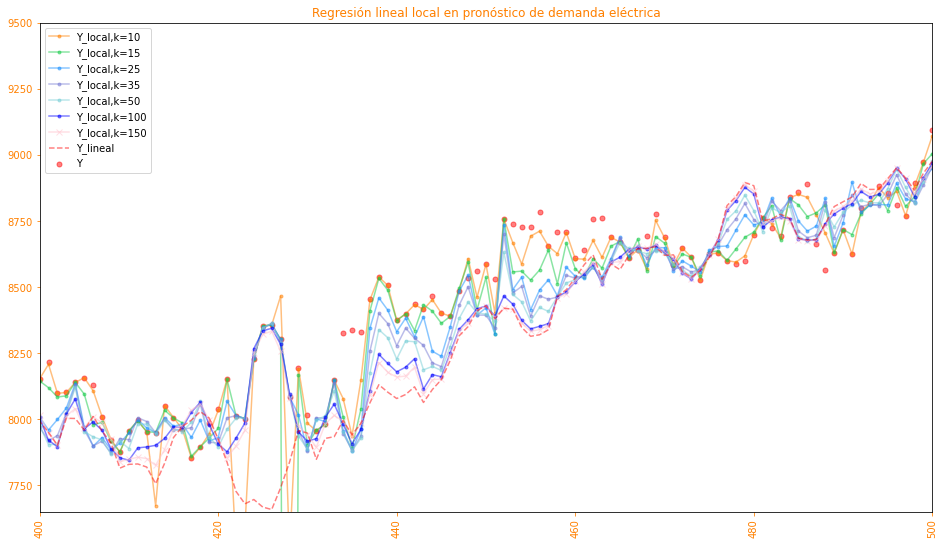

In [19]:
fig  = plt.figure(figsize=(16,9))
axes = fig.add_subplot(1, 1, 1)
#plt.style.use("seaborn-poster")
axes.legend()
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff';
mytitle = plt.title('Regresión lineal local en pronóstico de demanda eléctrica') # get the title property handler #plt.getp(title_obj)
plt.setp(mytitle,    color=LETRASNARA)                                           # set the color of title to red
axes.xaxis.label.set_color(LETRASNARA)
axes.yaxis.label.set_color(LETRASNARA)
axes.tick_params(colors=LETRASNARA, which='both')

AUX = np.arange( len(Y) )
plt.scatter( AUX,Y,s=25,marker='o' , color = 'red'      , label = 'Y'              ,alpha=1/2)
axes.plot  ( Y_local_list[0], '.-' , color = LETRASNARA , label = 'Y_local,k=10'   ,alpha=1/2)
axes.plot  ( Y_local_list[1], '.-' , color = VERDE      , label = 'Y_local,k=15'   ,alpha=1/2)
axes.plot  ( Y_local_list[2], '.-' , color = AZUL       , label = 'Y_local,k=25'   ,alpha=1/2)
axes.plot  ( Y_local_list[3], '.-' , color = LILA       , label = 'Y_local,k=35'   ,alpha=1/2)
axes.plot  ( Y_local_list[4], '.-' , color = CYAN       , label = 'Y_local,k=50'   ,alpha=1/2)
axes.plot  ( Y_local_list[5], '.-' , color = 'blue'     , label = 'Y_local,k=100'  ,alpha=1/2)
axes.plot  ( Y_local_list[6], 'x-' , color = 'pink'     , label = 'Y_local,k=150'  ,alpha=1/2)
axes.plot  ( Y_pred         , '--' , color = 'red'      , label = 'Y_lineal'       ,alpha=1/2)
#axes.plot ( Y      , '.-'  , color = 'red'        , label = 'Y'  ,alpha=1/2)
#axes.plot ( Y_local, '.-'  , color = LETRASNARA   , label = 'Y_local'  ,alpha=1/2)
#axes.plot ( xspline[3], yspline[3] , '.-'  , color = VERDE   , label = 'orden=4'  ,alpha=1/2)
#axes.plot ( xspline[4], yspline[4] , '.-'  , color = AZUL   , label = 'orden=5'  ,alpha=1/12)
#plt.scatter( dfx_miss, dfy_miss, marker='x',  s=170 ,  color = 'red' , label = 'perdidos' ,alpha=1)

plt.axis([0,  600, 7400, 9800])
plt.axis([100,  200, 7650, 9500])
plt.axis([400,  500, 7650, 9500])
#plt.axis([-2,  100, 8100, 9600])
#plt.axis([300, 400, 7900, 9500])
plt.legend()  
plt.xticks(rotation=90)
plt.savefig('pronodemanda_t6_4.png', transparent=True)
plt.show()

# Intento de eliminar la singularidad en el cálculo de los coeficientes de regresión



## Algunas ligas útiles que se utilizaron se pueden encontrar aquí
* [Locally weighted linear Regression using Python](https://www.geeksforgeeks.org/locally-weighted-linear-regression-using-python/)*   
* [Kernel regression estimation](https://bookdown.org/egarpor/NP-UC3M/kre-i-kre.html)
* [Kernel Density Estimation and Non-Parametric Regression](https://towardsdatascience.com/kernel-density-estimation-and-non-parametric-regression-ecebebc75277) 
* [Libreria localreg](https://github.com/sigvaldm/localreg) 
* [tips-locally-weighted-linear-regression](https://www.kaggle.com/alincijov/tips-locally-weighted-linear-regression)

* [LOESS Smoothing data using local regression](https://towardsdatascience.com/loess-373d43b03564)
*  [LOWESS Smoother, STATSMODELS](https://www.statsmodels.org/dev/examples/notebooks/generated/lowess.html)
*   https://www.allendowney.com/blog/2019/04/01/local-regression-in-python/
*   https://www.geeksforgeeks.org/implementation-of-locally-weighted-linear-regression/
*   https://towardsdatascience.com/locally-weighted-linear-regression-in-python-3d324108efbf

In [16]:
R= np.asarray([2,4,5,6,7,8,5,6,3,2,4,7,3,4,2,4,6,8,5,3,45,6,8,9,6,4,6,8,3,4,3,1,2,5,9,8,4,7,6,5,3,2,5,7,3,5,3,2,4,5,2,6,7,5,5])
import numpy as np
rng = np.random.RandomState(42)
R = rng.random_sample((100, 3))
kdeGauss = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(R)
log_density = kdeGauss.score_samples(R[:3])

kdeEspane = KernelDensity(kernel='epanechnikov', bandwidth=0.05).fit(R)
